# Deep Learning From Above
**Get Intution of deep learning via Linear Regression**

**Sections**
* Function Definition
* Function Application
* Neural Network as a function - Concepts
* Neural Network - PyTorch Implementation


In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random

In [30]:
import torch
from torch.autograd import Variable

In [31]:
%matplotlib inline 

## Function Definition
There are 2 ways to characterize a function.
* **Function Schema** : Input and Output
* **Function Body** : Logic of how input is translated into output

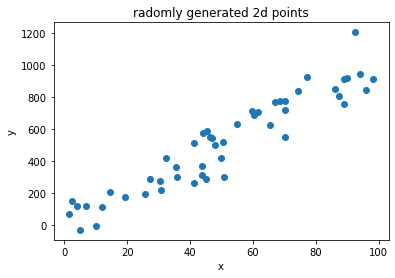

In [32]:
#Set hyperparameters for generating x,y data in 2D plane
beta=10
n=50
std_dev=100

#Generate sample 2D data 
x = np.random.rand(n) * 100
e = np.random.randn(n) * std_dev
y = x * beta + e

# plot 2D data
plt.xlabel('x')
plt.ylabel('y')
plt.title('radomly generated 2d points')
plt.scatter(x, y)

In [33]:
#Function schema (input, output)
list_xy = list(zip(x, y)) 
df_xy = pd.DataFrame(list_xy, columns = ['x', 'y'])  
df_xy.head()

,x,y
0,30.478129,274.478112
1,41.392538,266.674083
2,88.864637,916.567755
3,95.889187,842.686343
4,6.787636,117.417359


In [34]:
#Function body : Train using data
def learn_weight(x, y):
    X_mat=np.vstack((np.ones(len(x)), x)).T
    Y=y
    
    #calculate coefficients for the best fit line
    w_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(Y)
    
    return w_hat

#Function body : Infer using learnt model
def infer_y(x, w_hat):
    X_mat=np.vstack((np.ones(len(x)), x)).T
    y_hat = X_mat.dot(w_hat)
    
    return y_hat

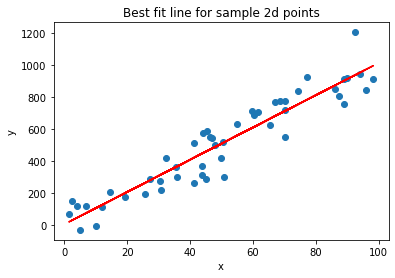

In [35]:
#Compare data and function approximating it
w_hat = learn_weight(x, y)
y_hat = infer_y(x, w_hat)

# plot data and predictions
plt.xlabel('x')
plt.ylabel('y')
plt.title('Best fit line for sample 2d points')
plt.scatter(x, y)
plt.plot(x, y_hat, color='red')

In [36]:
#print learned parameters(aka coefficients of the line)
w_hat

array([ 6.09552814, 10.08391003])

In [37]:
#Loss after applying linear algebra formula for best fit
#This loss is called MSE (mean square error loss)
loss_linalg = np.square(np.subtract(y,y_hat)).mean()
loss_linalg

9659.478700327321

## Function Application
Given data with labels(i.e. x and y values), we would like to approximate a function f(x) which is very close to y

|Scenario|Data=(x,y)|Function f s.t. y=f(x)|
|---|---|---|
| Best fit line| 2D points(x,y)  | y=f(x)  |
| Image classification | pixels representing picture  | image-class = f(image)   |
| Audio2Text  | wave representing utterances  | words = f(audio-wave)  |
| Translation  | sentences in multiple languages  | french-sentence = f(english-sentence)  |

Function is a very general concept and ability to write an aribtrary function can help solve various problems.  

## Neural Network - Concepts
We are looking for a machine that can generate functions given dataset representing x and y.
[Universal Approximation Theorem](https://medium.com/analytics-vidhya/you-dont-understand-neural-networks-until-you-understand-the-universal-approximation-theorem-85b3e7677126) gives us re-assurance that such a machine exists in our midst.
>_It states that a neural network with one hidden layer containing a sufficient but finite number of neurons can approximate any continuous function to a reasonable accuracy, under certain conditions for activation functions (namely, that they must be sigmoid-like)._

**Neural Network** is composed of stack of artificial neurons which transform an input x into output y. In essensce, it is a function composed of other functions.
* x is passed as input
* $\hat{y}$  is obtained as output
* y is the target output. Gap between y & $\hat{y}$ defines model quality. This gap is measured as loss.
* All layers between input and output layers are called hidden. If number of intermediary hidden layers are large, we call the network deep.

**Artificial Neuron**
<img src="images\BioNeuron.png" />

<br />
<br />

**Artificial Neural Network**
<img src="images\NeuralNetwork.png" />

### Terminology 
* **Data** : (x,y) x is input vector, y is label or output vector. e.g. 2D points.
* **Batch** : Subset of data that is processed in one pass through the network. 
* $\hat{y}$ : Approximating function that gets us close to y given x. Also referred as f(x) or f(w,x) where w is to be learnt. e.g red line in linear regression.
* **Weights** : Values of parameters learnt by the network represented by w. e.g. coefficients of best fit line.
* **Loss** : A function defined over the batch data that measures how far are we from the labels, a measure of _y-$\hat{y}$_. So this is function over approximating function f(x). e.g. summation of sqaure loss over all 2D points.
* **Forward pass** : Process of taking a batch of data(x) and tansforming it forward in the neural network such that we get y as output after the forward pass.
* **Backprop** : Process of adjusting weights by using the gradient of loss function to come up with better weights.
* **Optimizer** : Process that assists us to quickly find optimal values of weight so as to minimize loss. This relies on back-propagation.
* **Criterion** : A human readable measure of model quality. Criterion:Human = Loss: NeuralNetwork

### Development Loops
> We run development loop to come up with the desired approximating function given data. There are 2 loops, inner and outer
> * **Inner**:
> Take a step closer towards desired function by processing a subset of data. This is one pass through the neural network.
>* **Outer**
> Take a step closer towards desired function by processing all available data. We say that 1 epoch has elapsed.

Steps in development loop:
* Split data into 3 parts : train, validate, test
* For each epoch, build model(aka approximate function) using training data. Then use validate to see the quality of model. Rinse, Repeat.
* Finally, run prediction against test data to see how good the model generalizes

Development loops are part of a bigger *machine learning model life-cycle*.

***
$\mathbf{\text{Learning objective}}$<br/>
***
\begin{align}
w^{*} = \underset{w}{\textrm{arg min}} \; L(y,\hat{y}) \\
w^{*} = \underset{w}{\textrm{arg min}} \; L(y,f(w,x))
\end{align}

***
$\mathbf{\text{Back Prop}}$<br/>
***
1.&emsp;Initialize model with random weights $$w = w_{0}$$
2. For m = 1 to epochs:<br>
(a)&emsp;Run forward pass by estimating output given current weights $$\hat{y} = f(x,w)$$ 
(b)&emsp;Calculate loss based on the difference between estimated and real outputs. b is batch size. Square loss is an example of simple loss function. $$ L = \sum \limits_{j=1}^b (y-\hat{y})^2 $$ 
(c)&emsp;Calculate loss gradient with respect to weight and use it to update the weight parameter. Alpha is step size or learning rate. $$ w = w - \nabla_{w} L * \alpha $$
(d)&emsp;Stop when Loss is very small or when patience runs out


## Neural Network - PyTorch Implementation

![PyTorch](images/PyTorch.jpg)

### PyTorch : Machine Learning Framework
* **Computational Graph** to represent neural network. This gives us ability to backprop using diffrentiation.
* **Hardware Acceleration** using GPU & TPU for efficient computation on realistic problems. This is achieved through **CUDA** ( Compute Unified Device Architecture) , a parallel computing platform and application programming interface.

### Implementation Steps
* Reshape Data
* Build neural network using Pytorch's nn module
* Run training loop & build model
* Model visualization

In [38]:
#Reshape data so that it is suitable for training
x_train = np.array(x, dtype=np.float32)
x_train = x_train.reshape(-1, 1)

y_train = np.array(y, dtype=np.float32)
y_train = y_train.reshape(-1, 1)

print("Total rows for x :%3d, columns : %2d" % x_train.shape)
print("Total rows for y :%3d, columns : %2d" % y_train.shape)

Total rows for x : 50, columns :  1
Total rows for y : 50, columns :  1


In [39]:
#Sample x, y training data after shaping for neural net
x_train[0:5,],y_train[0:5,]

(array([[30.478128],
        [41.39254 ],
        [88.86464 ],
        [95.88918 ],
        [ 6.787636]], dtype=float32),
 array([[274.47812],
        [266.67407],
        [916.56775],
        [842.68634],
        [117.41736]], dtype=float32))

In [40]:
#create a class for linear regression that represents neural network model
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [41]:
#create a neural network template for linear regression task, data to be fed later during training

#Hyper-Parameters
inputDim = 1        # takes variable 'x' , single neuron
outputDim = 1       # takes variable 'y' , single neuron
alpha = 0.5 * 1e-4  # learning-rate
epochs = 100000     # number of iterations through the data

#Model definition (no data)
model = linearRegression(inputDim, outputDim)

#Model evaluation and optimizer (no data)
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=alpha)

In [42]:
print(model)

linearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [43]:
#Loss stabilizing around the value that linear algebra got

# Training loop through number of epochs 
for epoch in range(epochs):
    
    # Converting inputs and labels to Variable
    inputs = Variable(torch.from_numpy(x_train))
    labels = Variable(torch.from_numpy(y_train))

    # Clear gradient buffers for each epoch
    optimizer.zero_grad()

    # get output from the model, given the inputs. This calls the forward method in the neural network class.
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters using the gradients stored
    optimizer.step()

    # print loss periodically
    if epoch%10000 == 0 :
        print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 298418.3125
epoch 10000, loss 9663.291015625
epoch 20000, loss 9661.8759765625
epoch 30000, loss 9660.98828125
epoch 40000, loss 9660.427734375
epoch 50000, loss 9660.0751953125
epoch 60000, loss 9659.853515625
epoch 70000, loss 9659.71484375
epoch 80000, loss 9659.62890625
epoch 90000, loss 9659.572265625


In [44]:
#print learned parameters from neural network(aka coefficients of the line)
for param in model.parameters():
    if param.requires_grad:
        print(param.data)


tensor([[10.0916]])
tensor([5.5919])


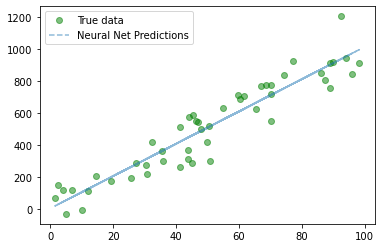

In [45]:
#Model evaluation visually
#No need of gradients in the testing phase
with torch.no_grad(): 
    inputs = Variable(torch.from_numpy(x_train))
    predicted = model(inputs).data.numpy()

plt.clf()
plt.plot(x_train, y_train, 'go', label='True data', alpha=0.5)
plt.plot(x_train, predicted, '--', label='Neural Net Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()

## Summary
* Deep Learning gives us a generic way to write arbitrary function given inputs(x) & labels(y). This is a very general machine and has proven itself in perception tasks.
* Deep Learning machinery is based on real numbers.
    * Need a way to translate input & output in numbers. For linear regression, this was not a problem but for language translation we need to tackle this.
    * Need a notion of model quality that is diffrentiable. We call it Loss.